In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%load_ext nb_black
%matplotlib inline
from IPython.display import set_matplotlib_formats
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import logging
import jax
from math import log, exp, sqrt
from concurrent.futures import ThreadPoolExecutor, ProcessPoolExecutor

# from estimate import posterior_decoding, sample_paths
from bmws.sim import sim_admix
from bmws.plotting import plot_summary, compute_rmse, bias_variance
from itertools import combinations_with_replacement, product

rng = np.random.default_rng()

N_SIMULATIONS = 10
N_EM_ITERATIONS = 3
set_matplotlib_formats("svg")

DEBUG:absl:Finished tracing + transforming prim_fun for jit in 0.0002570152282714844 sec
DEBUG:absl:Initializing backend 'interpreter'
DEBUG:absl:Backend 'interpreter' initialized
DEBUG:absl:Initializing backend 'cpu'
DEBUG:absl:Backend 'cpu' initialized
DEBUG:absl:Initializing backend 'tpu_driver'
INFO:absl:Unable to initialize backend 'tpu_driver': NOT_FOUND: Unable to find driver in registry given worker: 
DEBUG:absl:Initializing backend 'cuda'
INFO:absl:Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
DEBUG:absl:Initializing backend 'rocm'
INFO:absl:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
DEBUG:absl:Initializing backend 'tpu'
INFO:absl:Unable to initialize backend 'tpu': INVALID_ARGUMENT: TpuPlatform is not available.
DEBUG:absl:Finished tracing + transforming <lambda> for jit in 0.0005204677581787109 sec
DEBUG:absl:Compiling <lambda> (140020692192048 for args (S

<IPython.core.display.Javascript object>

## Define standard models for demography and selection 

In [3]:
T = 7
s_mdls = [
    {"s": [0.01] * (T - 1), "h": [0.5] * (T - 1), "f0": 0.1},
    #    {"s": [0.02] * 50 + [-0.02] * 50, "h": [0.5] * 100, "f0": 0.1},
    {
        "s": [0.02 * np.cos(np.pi * x / 99) for x in range(T - 1)],
        "h": [0.5] * (T - 1),
        "f0": 0.1,
    },
    {"s": (([0.02] * 20 + [-0.02] * 20) * 3)[: T - 1], "h": [0.5] * (T - 1), "f0": 0.5},
]
s_names = ["const", "switch", "fluc"]

gr = exp(log(10) / (T - 1))
Ne_mdls = [
    [10000] * (T - 1),  # constant
    [round(10000 * gr ** (10 * int(x / 10))) for x in range(T - 1)],  # exp growth
    [10000] * 40 + [1000] * 20 + [10000] * 40,  # bottleneck
]
Ne_names = ["const", "exp", "bottle"]

<IPython.core.display.Javascript object>

## Performance under standard models with admixture
For each model, we will assume that there are $K=2$ populations, and that the selection model is acting in one of them, whereas in the other model, there is no selection.

In [4]:
# admixture loadings for each indivdual
N = 15
K = 2
thetas = np.random.dirichlet([1, 1.0], size=(T, N))
assert thetas.shape == (T, N, K)
samples = np.zeros([T, N], int)
samples[::1] = 1  # sample 100 haploids every 10th generation

<IPython.core.display.Javascript object>

## Testing one run
Set up the model so that the second population evolves neutrally

In [5]:
def convert_2pop(mdl):
    mdl = dict(mdl)  # constant
    for x in "sh":
        mdl[x] = np.array([mdl[x], np.zeros_like(mdl[x])]).T
    mdl["f0"] = np.array([mdl["f0"], mdl["f0"]])
    return mdl

<IPython.core.display.Javascript object>

In [6]:
%%time
res = sim_admix(
    convert_2pop(s_mdls[0]),
    1,
    thetas,
    samples,
    M=10,
    estimate_kwargs={"lam": 1e3, "gamma": 0.0},
)

DEBUG:absl:Finished tracing + transforming prim_fun for jit in 0.0005824565887451172 sec
DEBUG:absl:Finished tracing + transforming prim_fun for jit in 0.0006184577941894531 sec
DEBUG:absl:Compiling prim_fun (140020692565376 for args (ShapedArray(float64[]),).
DEBUG:absl:Finished XLA compilation of broadcast_in_dim in 0.02019524574279785 sec
DEBUG:absl:Finished tracing + transforming prim_fun for jit in 0.0006806850433349609 sec
DEBUG:absl:Compiling prim_fun (140020692565936 for args (ShapedArray(float64[2,2]),).
DEBUG:absl:Finished XLA compilation of reshape in 0.015420675277709961 sec
DEBUG:absl:Finished tracing + transforming _eb_loss for jit in 1.3943438529968262 sec
DEBUG:absl:Compiling _eb_loss (140020632454624 for args (ShapedArray(float64[2,2]), ShapedArray(float64[6,2]), ShapedArray(float64[7,15,2]), ShapedArray(int64[7,15,2]), ShapedArray(int64[7]), ShapedArray(float64[6,2])).
DEBUG:absl:Finished XLA compilation of _eb_loss in 3.3523693084716797 sec


what: f2: fs1/n/d/i/nnz
( ( [-inf -inf]
    [-inf -inf]
    ( [[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]]
      [[12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.]
 [12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.]]
      [[       -inf -1.68639895 -1.79175947 -1.9095425  -2.0430739  -2.19722458
  -2.37954613 -2.60268969 -2.89037176 -3.29583687        -inf]
 [       -inf -1.68639895 -1.79175947 -1.9095425  -2.0430739  -2.19722458
  -2.37954613 -2.60268969 -2.89037176 -3.29583687        -inf]] ) )
  ( 1 0 )
  0
  15 )
what: f2: fs1/n/d/i/nnz
( ( [-inf -inf]
    [-inf -inf]
    ( [[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]
 [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11.]]
      [[12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.]
 [12. 11. 10.  9.  8.  7.  6.  5.  4.  3.  2.]]
      [[       -inf -1.43950789 -1.62361894 -1.82688839 -2.05390308 -2.31118593
  -2.60851206 -2.961626   -3.39873039 -3.97993469        -inf]
 [       -inf -1.54014981 -1.693752

AttributeError: 'numpy.ndarray' object has no attribute 'params'

<IPython.core.display.Javascript object>

In [9]:
%debug

> /home/terhorst/opt/py310/lib/python3.10/site-packages/jax/_src/lax/control_flow/loops.py(198)<listcomp>()
    196 
    197   try:
--> 198     lengths = [x.shape[0] for x in xs_flat]
    199   except AttributeError as err:
    200     msg = "scan got value with no leading axis to scan over: {}."

ipdb> up
> /home/terhorst/Dropbox (University of Michigan)/Research/selection_hmm/code/bmws/betamix.py(344)_binom_sampling_admix()
    342         return (fs2, ll, i + 1), None
    343 
--> 344     (fs2, ll, _), _ = lax.scan(apply, (fs, 0.0, 0), data)
    345     return (fs2, ll)
    346 

    [... skipped 2 hidden frame(s)]

ipdb> p data
Dataset(thetas=Traced<ShapedArray(float64[15,2])>with<DynamicJaxprTrace(level=0/1)>, obs=Traced<ShapedArray(int64[15,2])>with<DynamicJaxprTrace(level=0/1)>, nzi=Traced<ShapedArray(int64[])>with<DynamicJaxprTrace(level=0/1)>)
ipdb> p data.nzi.shape
()
ipdb> q


<IPython.core.display.Javascript object>

DEBUG:absl:Finished tracing + transforming prim_fun for jit in 0.0007159709930419922 sec
DEBUG:absl:Compiling prim_fun (140004931801456 for args (ShapedArray(int64[], weak_type=True), ShapedArray(int64[], weak_type=True)).
DEBUG:absl:Finished XLA compilation of lt in 0.018818140029907227 sec
DEBUG:absl:Finished tracing + transforming prim_fun for jit in 0.0006656646728515625 sec
DEBUG:absl:Compiling prim_fun (140004931807696 for args (ShapedArray(int64[], weak_type=True), ShapedArray(int64[], weak_type=True)).
DEBUG:absl:Finished XLA compilation of add in 0.01647806167602539 sec
DEBUG:absl:Finished tracing + transforming prim_fun for jit in 0.0005228519439697266 sec
DEBUG:absl:Compiling prim_fun (140005468841488 for args (ShapedArray(bool[], weak_type=True), ShapedArray(int64[], weak_type=True), ShapedArray(int64[], weak_type=True)).
DEBUG:absl:Finished XLA compilation of select_n in 0.015976428985595703 sec
DEBUG:absl:Finished tracing + transforming prim_fun for jit in 0.0004515647888

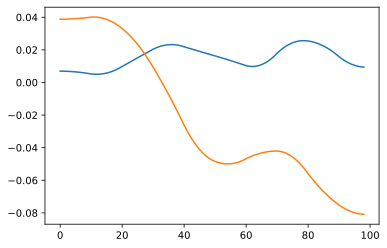

<IPython.core.display.Javascript object>

In [9]:
plt.plot(res["s_hat"][:, 0])
plt.plot(res["s_hat"][:, 1])

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(12, 12))

axs[0][0].axis("off")

optimal_lambda = [5, 4, 3]

std_res = pd.DataFrame(columns=["Scenario", "Demog", "Select", "iter", "RMSE"])

for i in range(3):
    axs[i + 1][0].plot(range(1, 101), Ne_mdls[i], color="black")

for j in range(3):
    axs[0][j + 1].plot(range(1, 101), s_mdls[j]["s"], color="black")

std_res = []



with ThreadPoolExecutor() as pool:
    for i in range(3):
        for j in range(3):
            res = []
            futs = [
                (
                    seed,
                    pool.submit(
                        sim_admix,
                        convert_2pop(s_mdls[j]),
                        seed=12345 + seed,
                        lam=10 ** optimal_lambda[j],
                        Ne=Ne_mdls[i],
                        em_iterations=N_EM_ITERATIONS,
                    ),
                )
                for seed in range(N_SIMULATIONS)
            ]
            for seed, f in futs:
                this_res = f.result()
                res.append(this_res)
#                 rmse = compute_rmse(this_res["s_hat"], s_mdls[i]["s"])
#                 std_res.append(
#                     {
#                         "s_mdl": s_names[i],
#                         "Ne_mdl": Ne_names[i],
#                         "iter": seed,
#                         "sampling": "100-10",
#                         "rmse": rmse,
#                     }
#                 )
#             x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in res])
#             plot_summary(axs[i + 1][j + 1], x, y, s_mdls[j]["s"])

#     std_res = pd.DataFrame(std_res)

## Performance if we incorrectly assume that Ne is constant 

In [ ]:
fig, axs = plt.subplots(ncols=4, nrows=3, figsize=(12, 9))

axs[0][0].axis("off")
optimal_lambda = [5, 4, 3]

for i in range(1, 3):
    axs[i][0].plot(range(1, 101), Ne_mdls[i], color="black")

for j in range(3):
    axs[0][j + 1].plot(range(1, 101), s_mdls[j]["s"], color="black")

with ThreadPoolExecutor() as pool:
    for i in range(3):
        for j in range(1, 3):
            futs = [
                pool.submit(
                    sim_and_fit,
                    s_mdls[i],
                    seed=12345 + seed,
                    lam=10 ** optimal_lambda[i],
                    Ne=Ne_mdls[j],
                    Ne_fit=[10000] * len(s_mdls[i]["s"]),
                    em_iterations=N_EM_ITERATIONS,
                )
                for seed in range(N_SIMULATIONS)
            ]
            res = [f.result() for f in futs]
            x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in res])
            plot_summary(axs[j][i + 1], x, y, s_mdls[i]["s"])

## See how RMSE changes as sample size and frequency change

In [ ]:
ns = [1, 10, 100]
ks = [5, 10, 20]
size_res = []  # total results to save

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(12, 12))
optimal_lambda = [5, 4, 3]

axs[0][0].axis("off")
std_res = pd.DataFrame(columns=["Scenario", "Demog", "Select", "iter", "RMSE"])
for i in range(3):
    axs[i + 1][0].plot(range(1, 101), Ne_mdls[i], color="black")
for j in range(3):
    axs[0][j + 1].plot(range(1, 101), s_mdls[j]["s"], color="black")


with ThreadPoolExecutor() as pool:
    for i, j in product(range(3), range(3)):
        plot_res = []  # results to make this subplot
        futs = [
            (
                nn,
                kk,
                seed,
                pool.submit(
                    sim_and_fit,
                    s_mdls[j],
                    seed=12345 + seed,
                    lam=10 ** optimal_lambda[j],
                    Ne=Ne_mdls[i],
                    n=nn,
                    k=kk,
                    em_iterations=N_EM_ITERATIONS,
                ),
            )
            for nn, kk, seed in product(ns, ks, range(N_SIMULATIONS))
        ]
        for nn, kk, seed, f in futs:
            this_res = f.result()
            rmse = compute_rmse(this_res["s_hat"], s_mdls[j]["s"])
            plot_res.append(
                {
                    "s_mdl": s_names[j],
                    "Ne_mdl": Ne_names[j],
                    "iter": seed,
                    "sampling": str(nn) + "-" + str(kk),
                    "rmse": rmse,
                }
            )

        size_res.extend(plot_res)
        plot_res = pd.DataFrame(plot_res)
        axs[i + 1][j + 1].tick_params(labelsize=6)
        axs[i + 1][j + 1].xaxis.label.set_visible(False)
        axs[i + 1][j + 1].title.set_visible(False)
        plot_res.boxplot(ax=axs[i + 1][j + 1], by="sampling", column=["rmse"])

fig.suptitle(None)
size_res = pd.DataFrame(size_res)

## Smoothing parameter

In [ ]:
log10_lambda = [1, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6]
lam_res = []  # total results to save

fig, axs = plt.subplots(ncols=4, nrows=4, figsize=(12, 12))

axs[0][0].axis("off")
std_res = pd.DataFrame(columns=["Scenario", "Demog", "Select", "iter", "RMSE"])
for i in range(3):
    axs[i + 1][0].plot(range(1, 101), Ne_mdls[i], color="black")
for j in range(3):
    axs[0][j + 1].plot(range(1, 101), s_mdls[j]["s"], color="black")

lam_res = []
with ThreadPoolExecutor() as pool:
    for i, j in product(range(3), range(3)):
        plot_res = []  # results to make this subplot
        for lam in log10_lambda:
            futs = [
                pool.submit(
                    sim_and_fit,
                    s_mdls[j],
                    seed=12345 + seed,
                    lam=10 ** lam,
                    Ne=Ne_mdls[i],
                    em_iterations=N_EM_ITERATIONS,
                )
                for seed in range(N_SIMULATIONS)
            ]
            this_res = [f.result() for f in futs]
            x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in this_res])
            b, v, m = bias_variance(y, s_mdls[j]["s"])
            plot_res.append(
                {
                    "s_mdl": s_names[j],
                    "Ne_mdl": Ne_names[j],
                    "lambda": lam,
                    "rmse": m,
                    "rbias": b,
                    "rvar": v,
                }
            )

        lam_res.extend(plot_res)
        plot_res = pd.DataFrame(plot_res)
        axs[i + 1][j + 1].tick_params(labelsize=6)
        axs[i + 1][j + 1].xaxis.label.set_visible(False)
        axs[i + 1][j + 1].title.set_visible(False)
        axs[i + 1][j + 1].plot(plot_res["lambda"], plot_res["rmse"], color="tab:red")
        axs[i + 1][j + 1].plot(plot_res["lambda"], plot_res["rbias"], color="tab:green")
        axs[i + 1][j + 1].plot(plot_res["lambda"], plot_res["rvar"], color="tab:blue")


fig.suptitle(None)
lam_res = pd.DataFrame(lam_res)

## Simulations using the sampling distribution of the ancient European samples

In [ ]:
samples = pd.read_csv("allbrit.meta", sep="\t")
samples["GenBP"] = samples.DateBP // 29  # assume 29 years per-generation
counts = samples.GenBP.value_counts().sort_index()
sizes, times = counts.values, np.array(counts.index)

T = times[-1]
s2_mdls = [
    {"s": [0.01] * T, "h": [0.5] * T, "f0": 0.1},
    {
        "s": [0.02 * np.cos(np.pi * x / (T - 1)) for x in range(T)],
        "h": [0.5] * T,
        "f0": 0.1,
    },
    {"s": (([0.02] * 20 + [-0.02] * 20) * 6)[:T], "h": [0.5] * T, "f0": 0.5},
]
gr = exp(log(100) / T)
Ne_mdl2 = [round(10000 * gr ** (10 * int(x / 10))) for x in range(T)]  # exp growth

In [ ]:
fig, axs = plt.subplots(
    ncols=3, nrows=2, figsize=(12, 6))

optimal_lambda = [5, 4, 2]


with ThreadPoolExecutor() as pool:
    for j in range(3):
        futs = [pool.submit(
            sim_and_fit,
            s2_mdls[j], seed=12345 + seed, lam=10**optimal_lambda[j], Ne=Ne_mdl2, k=times, n=sizes)
                for seed in range(N_SIMULATIONS)
               ]
        res = [f.result() for f in futs]    
        x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in res])
        plot_summary(axs[0][j], x, y, s2_mdls[j]["s"])

    log10_lambda = [1, 2, 2.5, 3, 3.5, 4, 4.5, 5, 6]

    for j in range(3):
        plot_res = []  # results to make this subplot
        for lam in log10_lambda:
            futs = [pool.submit(
                sim_and_fit,
                s2_mdls[j], seed=12345 + seed, lam=10 ** lam, Ne=10000, k=times, n=sizes,em_iterations=N_EM_ITERATIONS
            )
                    for seed in range(N_SIMULATIONS)
                   ]
            this_res = [f.result() for f in futs]
            x, y = zip(*[(range(len(rr["s_hat"])), rr["s_hat"]) for rr in this_res])
            b, v, m = bias_variance(y, s2_mdls[j]["s"])
            plot_res.append(
                {
                    "s_mdl": s_names[j],
                    "Ne_mdl": "Exp2",
                    "lambda": lam,
                    "rmse": m,
                    "rbias": b,
                    "rvar": v,
                }
            )


    plot_res = pd.DataFrame(plot_res)
    axs[1][j].tick_params(labelsize=6)
    axs[1][j].xaxis.label.set_visible(False)
    axs[1][j].title.set_visible(False)
    axs[1][j].plot(plot_res["lambda"], plot_res["rmse"], color="tab:red")
    axs[1][j].plot(plot_res["lambda"], plot_res["rbias"], color="tab:green")
    axs[1][j].plot(plot_res["lambda"], plot_res["rvar"], color="tab:blue")


fig.suptitle(None)
